## Hugget - Continuum Income Types

### Replication of Moll and SeHyoun Ahn matlab codes
### by Joao B. Duarte

In [81]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import scipy.sparse as sparse
from scipy.sparse.linalg import inv
from time import time
from scipy.stats import norm
import numpy.matlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

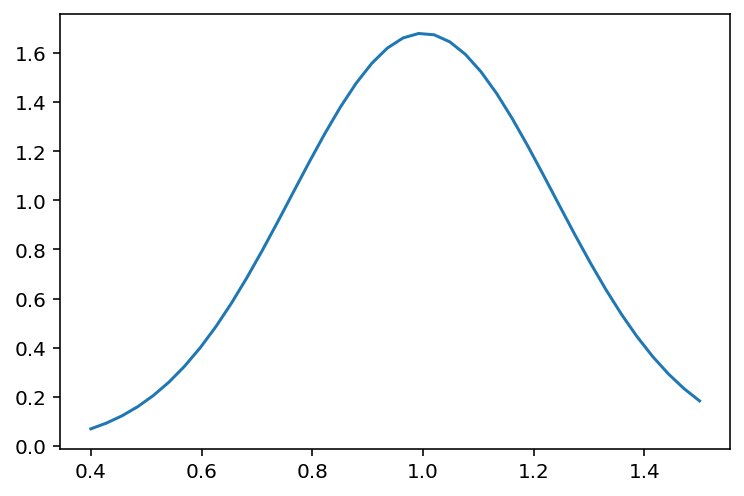

In [82]:
ga = 2 #CRRA utility with parameter gamma
r = 0.04 #interest rate
rho = 0.05 #discount rate

# #ORNSTEIN-UHLENBECK PROCESS dlog(z) = -the*log(z)dt + sig2*dW
# #STATIONARY DISTRIBUTION IS log(z) ~ N(0,Var) WHERE Var = sig2/(2*the)
# sig2 = 0.05
# # Corr = 0.85
# Corr = 0.97
# the = -log(Corr)
# Var = sig2/(2*the)
# logzmean = 0
# zmean = logzmean + exp(Var/2) #MEAN OF LOG-NORMAL DISTRIBUTION N(0,Var)

#ORNSTEIN-UHLENBECK IN LEVELS
sig2 = 0.05
Corr = 0.9
the = -np.log(Corr)
Var = sig2/(2*the)
zmean = 1

I=100
amin = -0.1 #borrowing constraint
amax = 30
a = np.linspace(amin,amax,I).reshape(I,1)
da = (amax-amin)/(I-1)

J=40
# zmin = exp(logzmean - 3 + Var/2)
# zmax = exp(logzmean + .3 + Var/2)
# zmin = 0.7
# zmax = 1.25
zmin = 0.4
zmax = 1.5
z = np.linspace(zmin,zmax,J)
dz = (zmax-zmin)/(J-1)
dz2 = dz**2

# mu = (the*(logzmean - log(z)) + sig2/2).*z #DRIFT (FROM ITO'S LEMMA)
# s2 = sig2.*z.**2 #VARIANCE (FROM ITO'S LEMMA)
#ORNSTEIN-UHLENBECK IN LEVELS
mu = the*(zmean - z) #DRIFT (FROM ITO'S LEMMA)
s2 = sig2*np.ones((1,J)) #VARIANCE (FROM ITO'S LEMMA)

# plot(log(z),normpdf(log(z),0,Var))
# plot(z,lognpdf(z,0,Var))

plt.plot(z,norm.pdf(z,zmean,Var))
plt.show()

In [83]:
aa = np.dot(a,np.ones((1,J)))
zz = np.ones((I,1))*z

maxit= 100
crit = 10**(-6)
Delta = 1000

Vaf = np.zeros((I,J))
Vab = np.zeros((I,J))
Vzf = np.zeros((I,J))
Vzb = np.zeros((I,J))
Vzz = np.zeros((I,J))
c = np.zeros((I,J))

#CONSTRUCT MATRIX Bswitch SUMMARIZING EVOLUTION OF z
chi =  - np.minimum(mu,0)/dz + s2/(2*dz2)
yy =  np.minimum(mu,0)/dz - np.maximum(mu,0)/dz - s2/dz2
zeta = np.maximum(mu,0)/dz + s2/(2*dz2)

#This will be the upperdiagonal of the B_switch
updiag = np.zeros((I,1)) #This is necessary because of the peculiar way spdiags is defined.
for j in range(0,J):
    updiag = np.vstack( (updiag,  np.matlib.repmat(zeta[0,j],I,1)) )
    

#This will be the center diagonal of the B_switch
centdiag = np.matlib.repmat(chi[0,0]+yy[0,0],I,1)
for j in range(1,J-1):
    centdiag = np.vstack( (centdiag, np.matlib.repmat(yy[0,j],I,1)) )
centdiag = np.vstack( (centdiag, np.matlib.repmat(yy[0,J-1] + zeta[0,J-1],I,1)) )


#This will be the lower diagonal of the B_switch
lowdiag = np.matlib.repmat(chi[0,2],I,1)
for j in range(2,J):
    lowdiag = np.vstack( (lowdiag,   np.matlib.repmat(chi[0,j],I,1)) )


# Add up the upper, center, and lower diagonal into a sparse matrix
# In Pyhton spdiags diagonals need to be stored row-wise
Aswitch = sparse.spdiags(centdiag.T,0,I*J,I*J)+sparse.spdiags(lowdiag.T,-I,I*J,I*J)+sparse.spdiags(updiag.T,I,I*J,I*J)

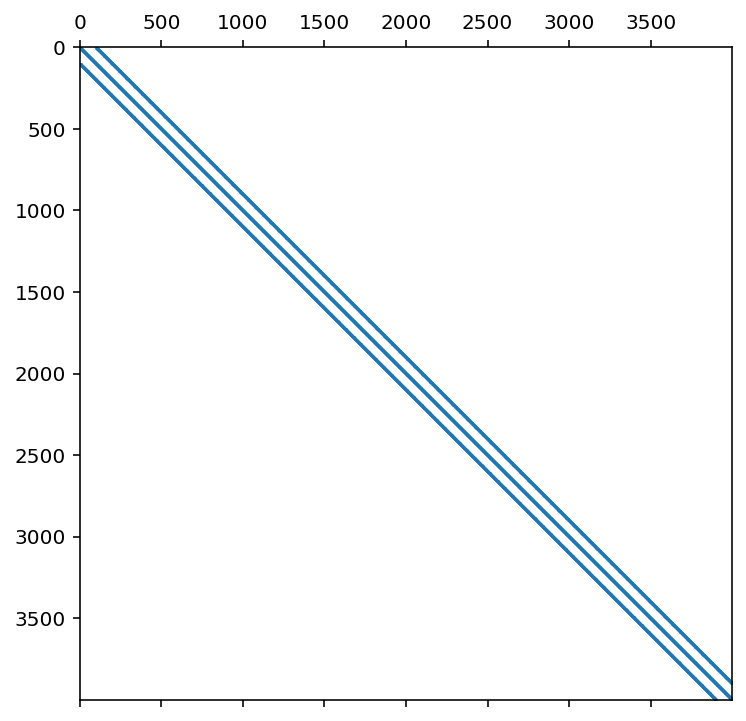

In [84]:
plt.figure(figsize = (6,6))
plt.spy(Aswitch, markersize=0.1)
plt.show()

In [85]:
#INITIAL GUESS
v0 = (zz + r*aa)**(1-ga)/(1-ga)/rho
v = v0

maxit = 20
dist = []

start = time()
for n in range(0,maxit):
    V = v
    
    # forward difference
    Vaf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
    Vaf[I-1,:] = (z + r*amax)**(-ga) #will never be used, but impose state constraint a<=amax just in case
    # backward difference
    Vab[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
    Vab[0,:] = (z + r*amin)**(-ga) #state constraint boundary condition

    I_concave = Vab > Vaf #indicator whether value function is concave (problems arise if this is not the case)

    #consumption and savings with forward difference
    cf = Vaf**(-1/ga)
    sf = zz + r*aa - cf
    #consumption and savings with backward difference
    cb = Vab**(-1/ga)
    sb = zz + r*aa - cb
    #consumption and derivative of value function at steady state
    c0 = zz + r*aa
    Va0 = c0**(-ga)

    # dV_upwind makes a choice of forward or backward differences based on
    # the sign of the drift
    If = sf > 0 #positive drift --> forward difference
    Ib = sb < 0 #negative drift --> backward difference
    I0 = (1-If-Ib) #at steady state
    #make sure backward difference is used at amax
    #     Ib(I,:) = 1 If(I,:) = 0
    #STATE CONSTRAINT at amin: USE BOUNDARY CONDITION UNLESS sf > 0:
    #already taken care of automatically

    Va_Upwind = Vaf*If + Vab*Ib + Va0*I0 #important to include third term

    c = Va_Upwind**(-1/ga)
    u = c**(1-ga)/(1-ga)

    #CONSTRUCT MATRIX A
    X = -np.minimum(sb,0)/da
    Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
    Z = np.maximum(sf,0)/da

    updiag = np.zeros(1) #This is needed because of the peculiarity of spdiags.
    for j in range(0,J):
        updiag=np.concatenate((updiag,Z[0:I-1,j], np.zeros(1)))


    centdiag = np.reshape(Y,(I*J,1), order = 'F')

    lowdiag = X[1:I,0]
    for j in range(1,J):
        lowdiag = np.concatenate( (lowdiag, np.zeros(1), X[1:I,j]) )


    AA = sparse.spdiags(centdiag.T,0,I*J,I*J)+sparse.spdiags(np.concatenate((updiag, np.zeros(1))),1,I*J,I*J) \
                + sparse.spdiags(np.concatenate((lowdiag, np.zeros(1))),-1,I*J,I*J)

    A = AA + Aswitch
    B = (1/Delta + rho)*sparse.eye(I*J) - A
    
    u_stacked = np.reshape(u,(I*J,1), order = 'F')
    V_stacked = np.reshape(V,(I*J,1), order = 'F')
    
    b = u_stacked + V_stacked/Delta
    
    V_stacked = sparse.linalg.spsolve(B, b) #SOLVE SYSTEM OF EQUATIONS
    
    V = np.reshape(V_stacked,(I,J), order = 'F')
    
    Vchange = V - v
    v = V

    dist.append( np.max(abs(Vchange)) )
    if dist[n] < crit:
        end = time()
        print('Value Function Converged, Iteration = %1.0f in %1.2f seconds' % (n, end-start))
        break
    


Value Function Converged, Iteration = 6 in 0.12 seconds


In [86]:
##########################
# FOKKER-PLANCK EQUATION #
##########################
AT = A.T
b = np.zeros((I*J,1))

#need to fix one value, otherwise matrix is singular
i_fix = 0
b[i_fix] = .1
row = np.hstack( (1, np.zeros(I*J-1)) )
AT[i_fix,:] = row

#Solve linear system
gg = sparse.linalg.spsolve(AT,b)
g_sum = np.dot(gg.T,np.ones((I*J,1))*da*dz)
gg = gg/g_sum

g = np.reshape(gg,(I,J), order = 'F')


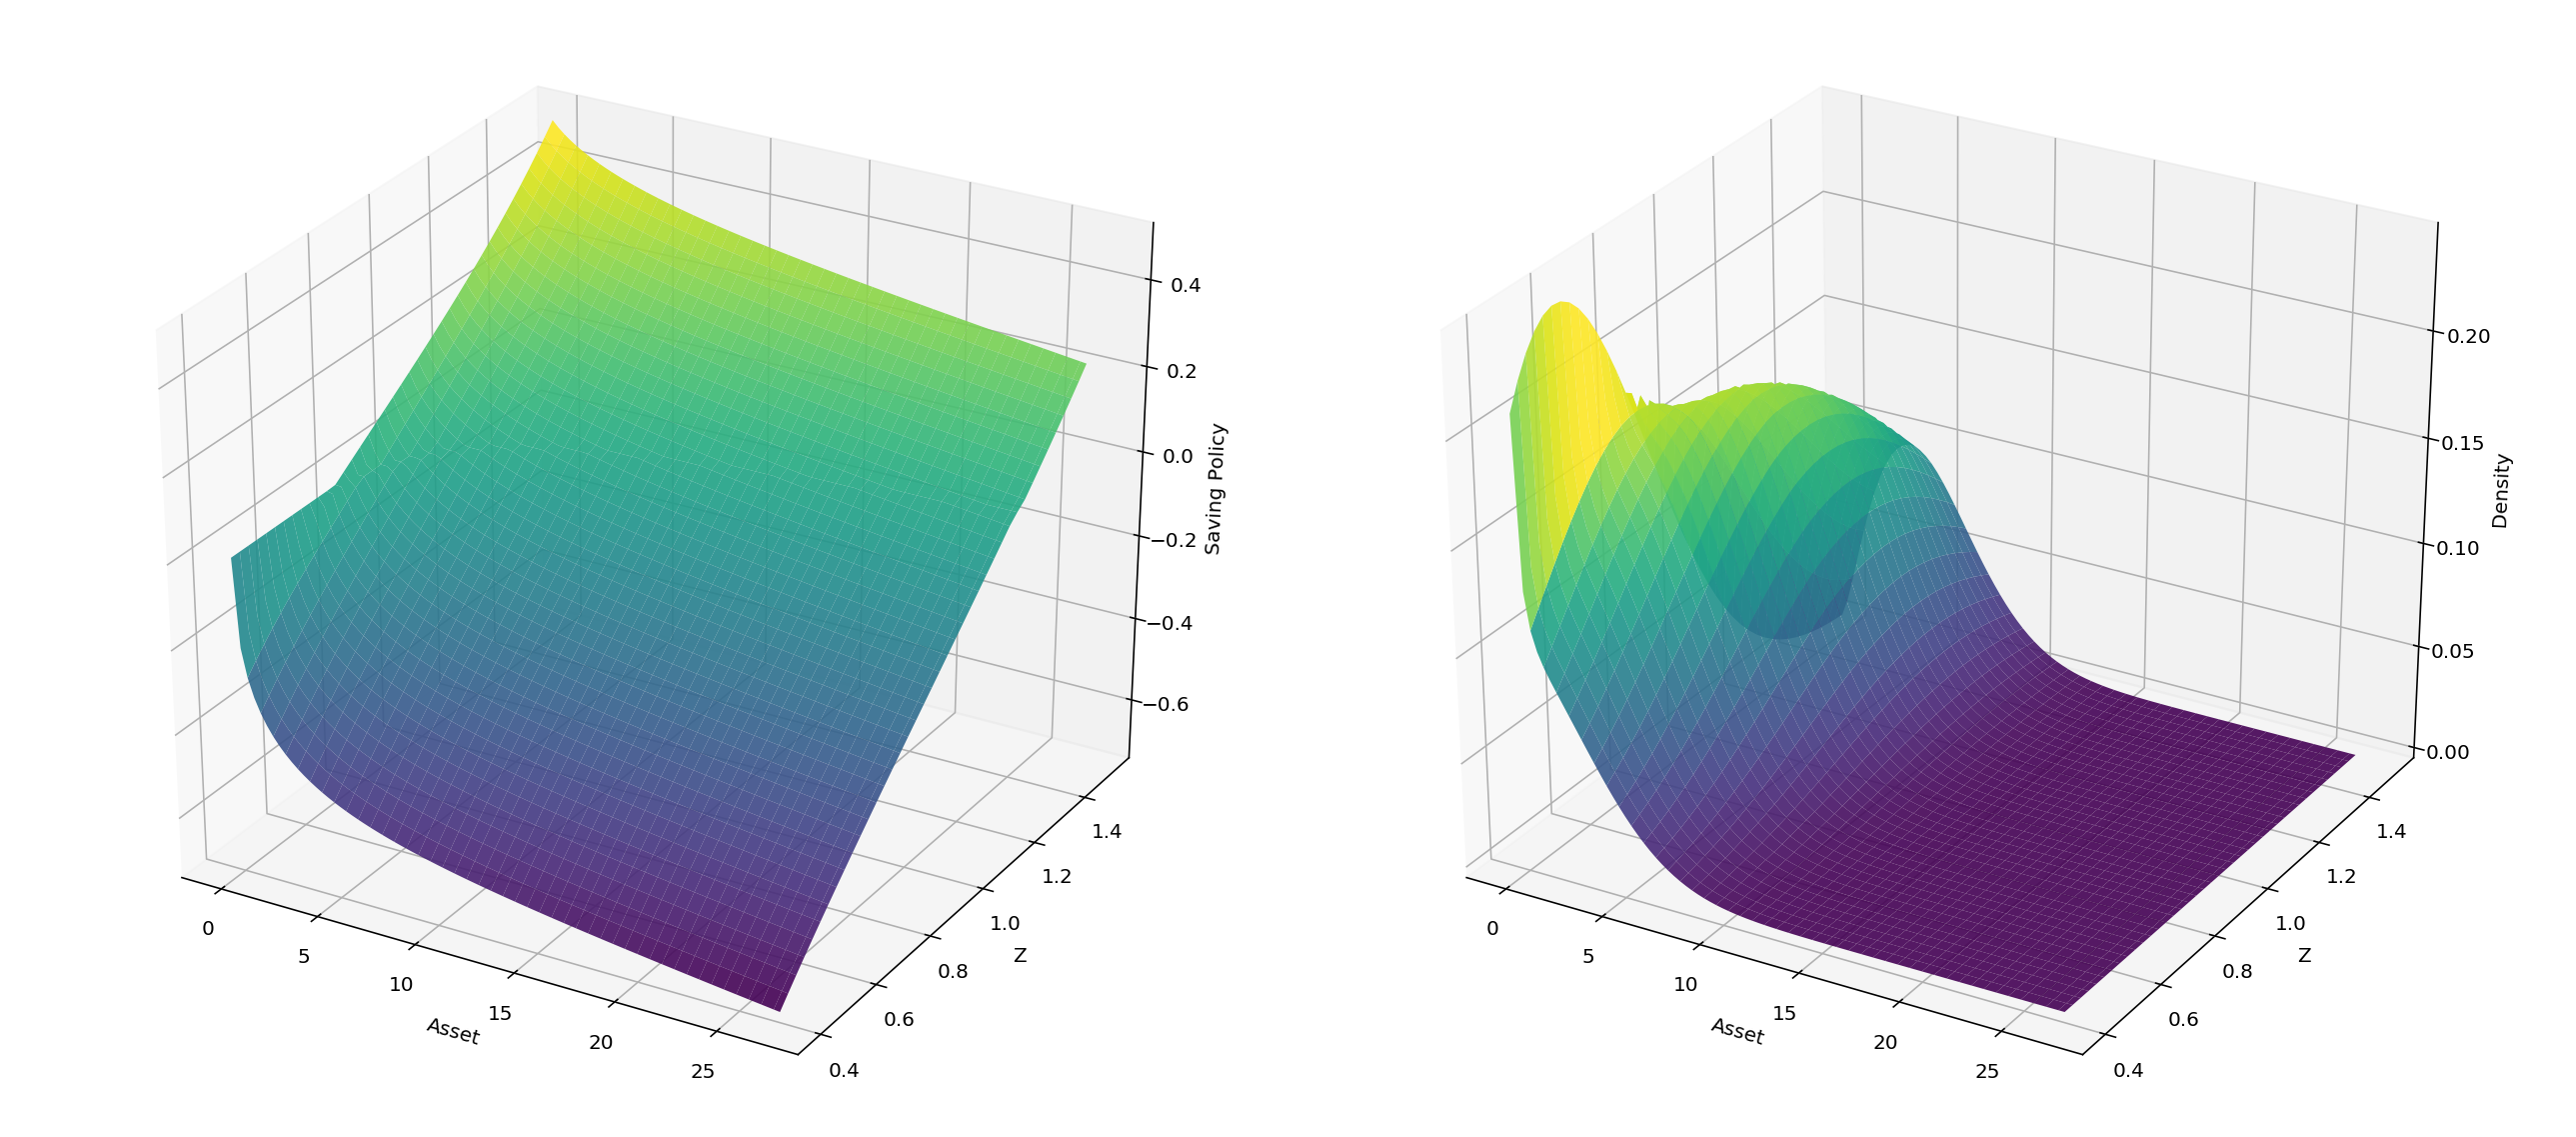

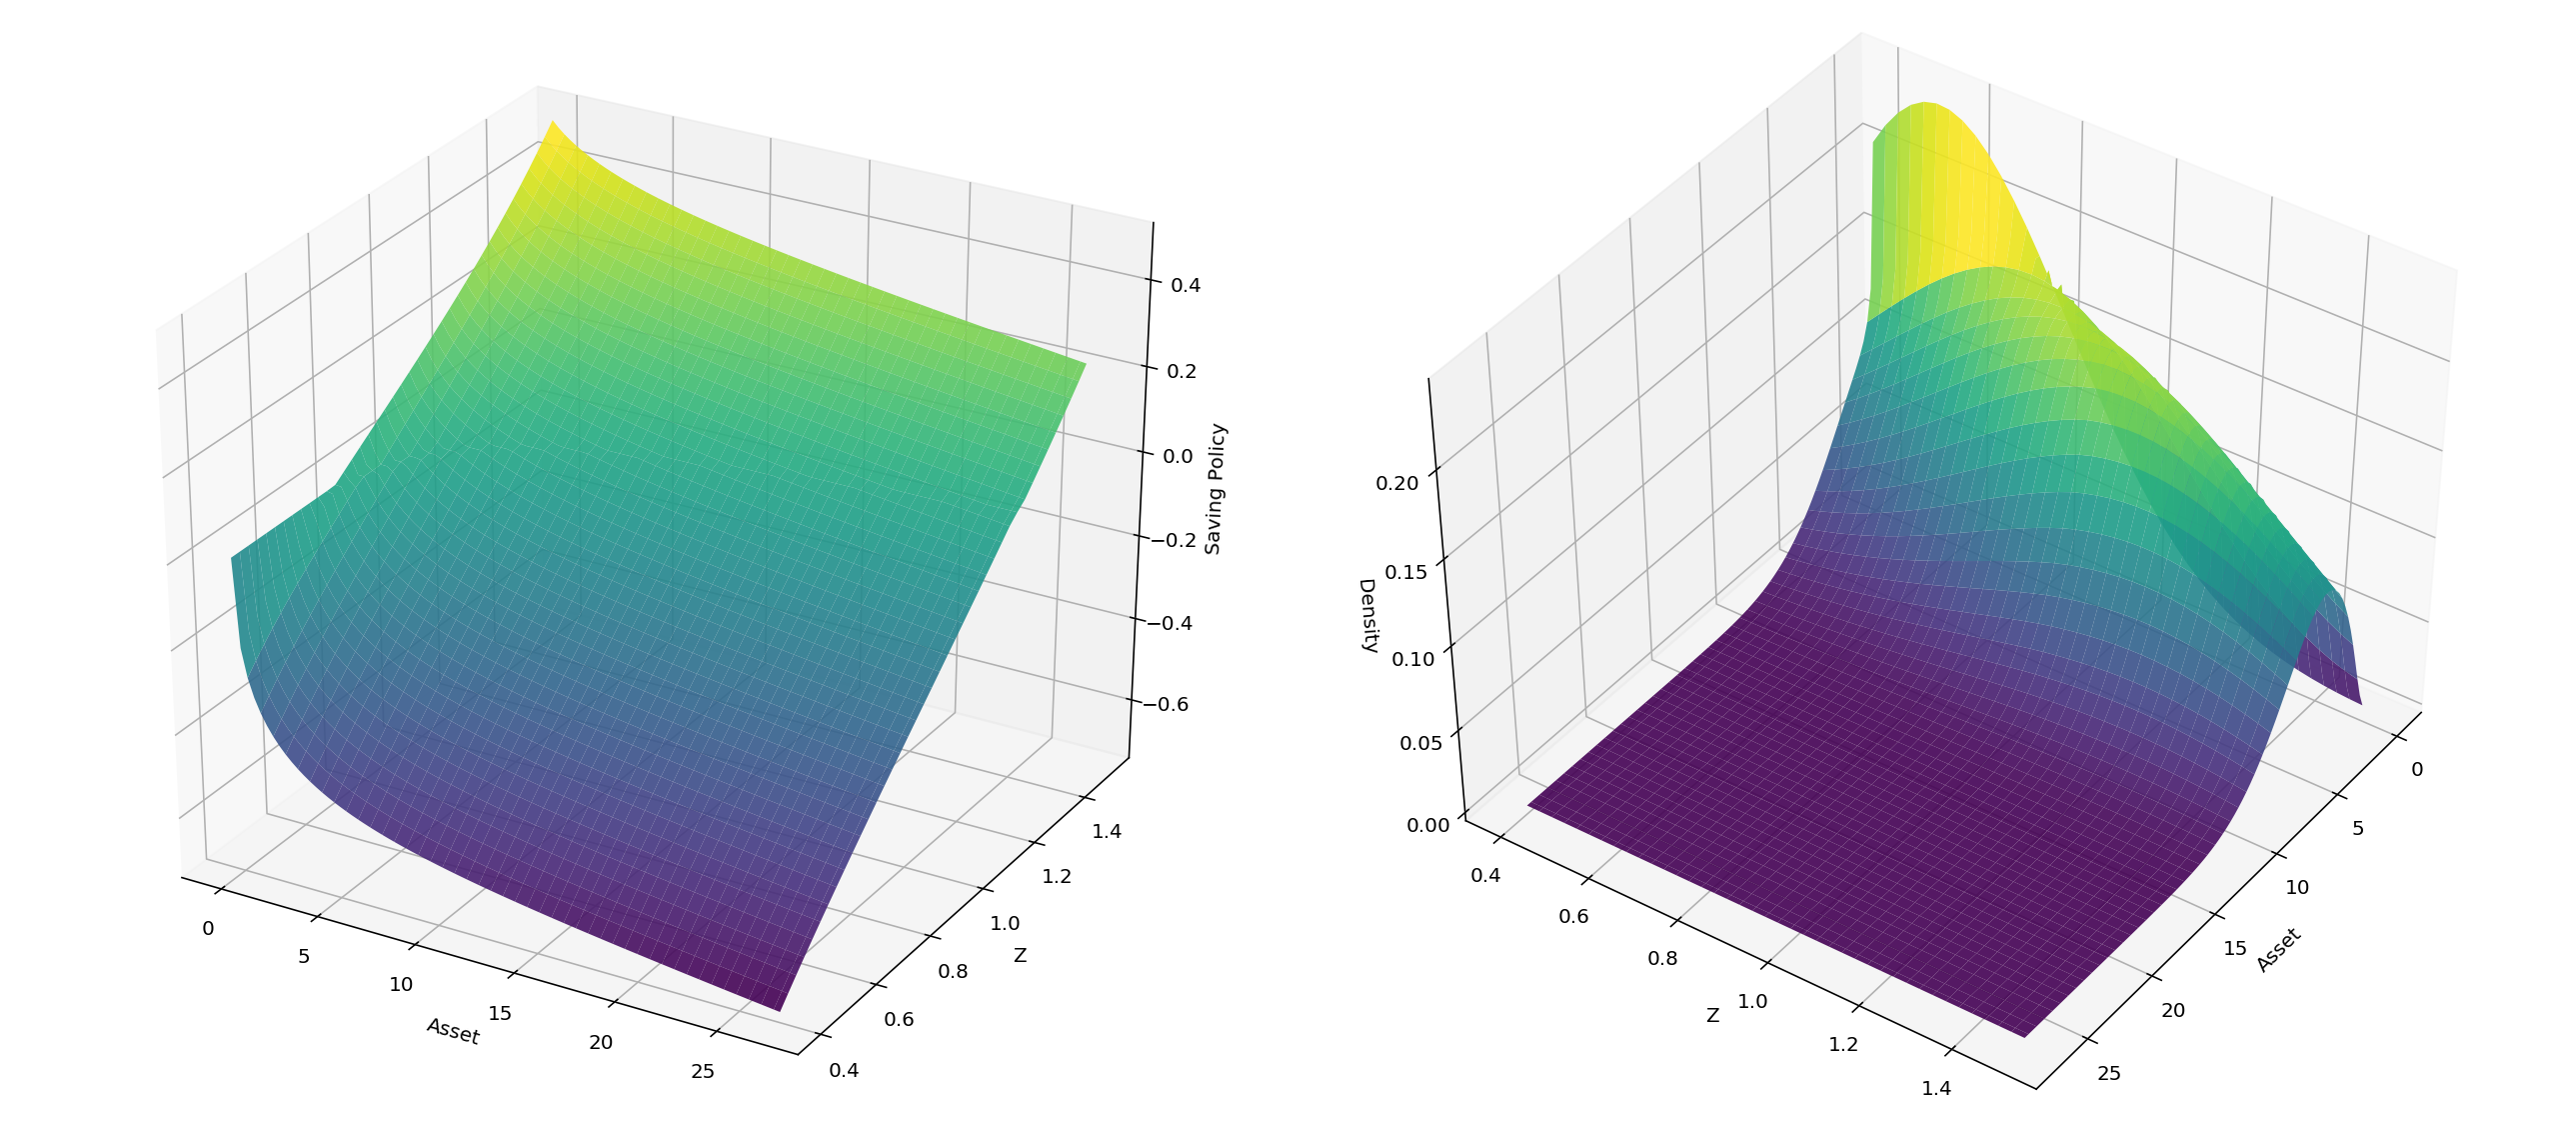

In [90]:
##########
# GRAPHS #
##########
#SAVINGS POLICY FUNCTION
ss = zz + r*aa - c

icut = 90
acut = a[0:icut]
sscut = ss[0:icut,:]
# set(gca,'FontSize',14)
# plot(a,ss,a,zeros(1,I),'--')
# xlabel('a')
# ylabel('s(a,z)')
# xlim([amin amax])

acut, z1 = np.meshgrid(acut, z)
        
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot_surface(acut.T,z1.T,sscut, cmap = 'viridis', alpha = 0.9)
ax.set_xlabel('Asset')
ax.set_ylabel('Z')
ax.set_zlabel('Saving Policy')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(acut.T,z1.T,g[0:icut,:], cmap = 'viridis', alpha = 0.9)
ax.set_xlabel('Asset')
ax.set_ylabel('Z')
ax.set_zlabel('Density')

plt.tight_layout()
plt.savefig('distributions_cont_incomeType.pdf') 
plt.show()

ax.view_init(45, 35)
fig